# **Multiclass Classification using Keras and TensorFlow on Food-101 Dataset**

In [1]:
import numpy as np
import os
import random
import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.python.keras.applications.efficientnet import *
# from tensorflow.python.keras.applications.efficientnet_v2 import EfficientNetV2S, EfficientNetV2L
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
import cv2

In [ ]:
# Fix error with cv2
# !apt-get update
# !apt-get install ffmpeg libsm6 libxext6  -y

### **Food-101 Data**

In [ ]:
# Check if GPU is enabled
# print(tf.__version__)
# print(tf.test.gpu_device_name())

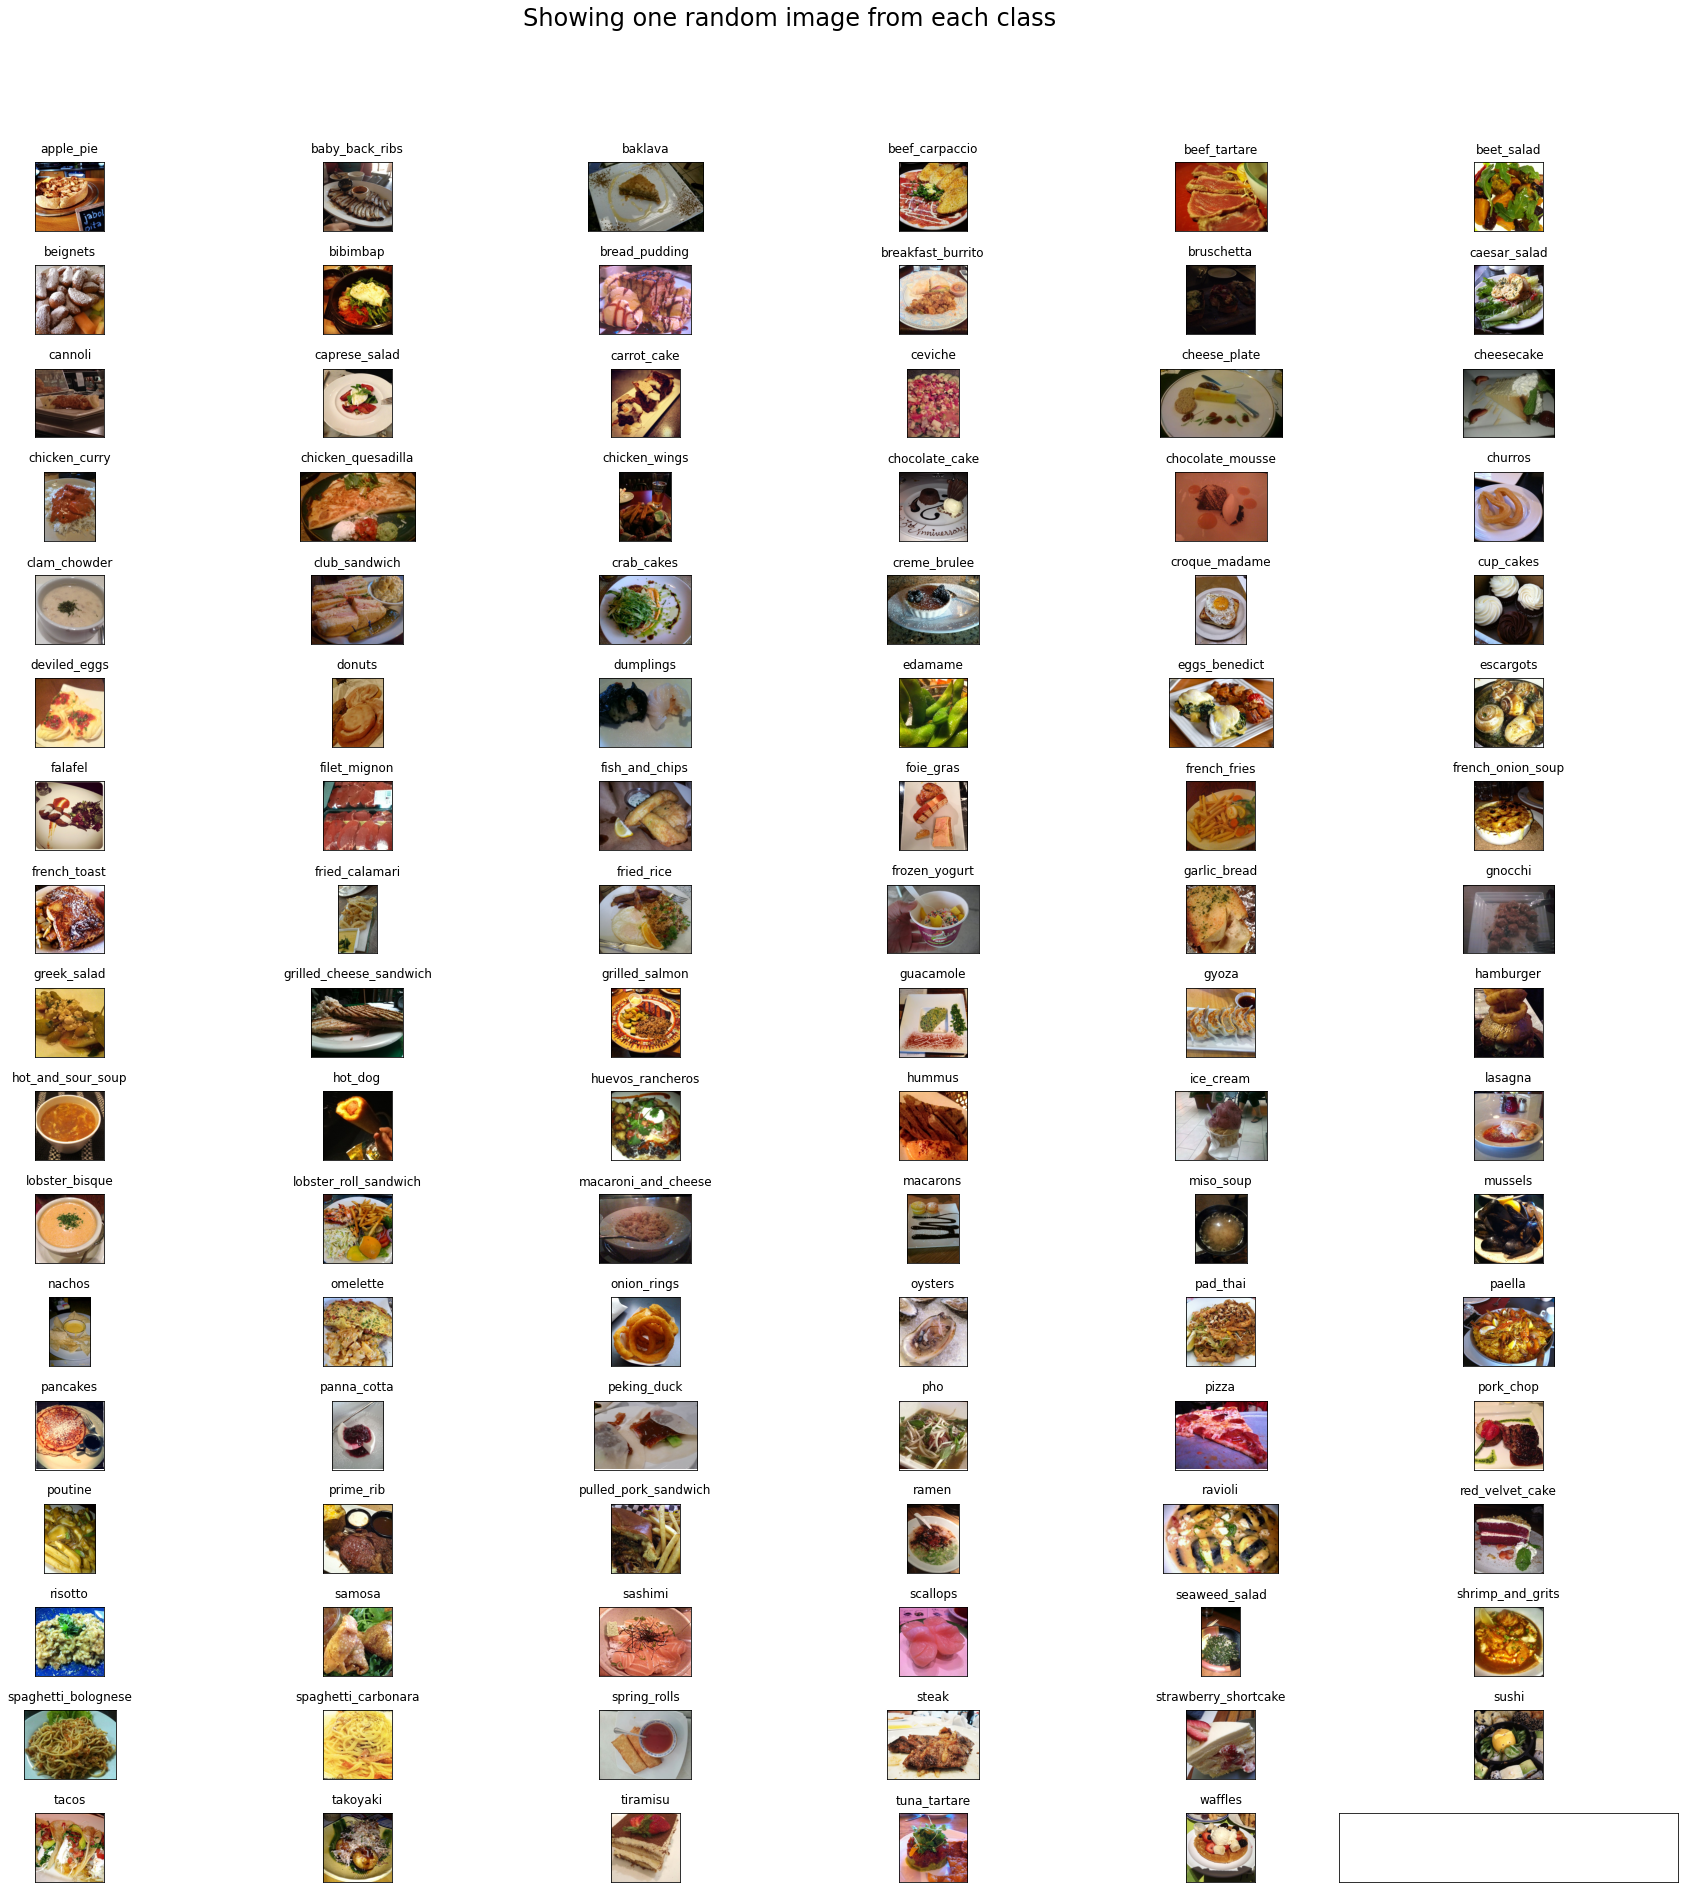

In [3]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "/workspace/persistent/food-101/images"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


In [7]:
%cd ..

/workspace/persistent


In [8]:
%pwd

'/workspace/persistent'

In [9]:
%cd food-101

/workspace/persistent/food-101


In [10]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type f | wc -l
print("\nTotal number of samples in test folder")
!find test -type f | wc -l

Total number of samples in train folder
75750

Total number of samples in test folder
25250


In [ ]:
# List of all 101 types of foods(sorted alphabetically)
# del foods_sorted[0] # remove .DS_Store from the list

# foods_sorted

In [11]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
find: ‘test_mini’: No such file or directory
0


### Data Augmentation and Acc/Loss Visualization

In [12]:
K.clear_session()
n_classes = 100
img_width, img_height = 299, 299
train_data_dir = 'train'
validation_data_dir = 'test'
nb_train_samples = 75750
nb_validation_samples = 25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')



Found 75750 images belonging to 102 classes.
Found 25250 images belonging to 101 classes.


In [13]:
# Plot Accuracy and Loss of the model
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()

def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

def plot_Acc_and_Loss(history,title):
    # plot model accuracy
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    # plot model loss
    plt.subplot(1,2,2)
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

### MODEL1: ResNet152V2

In [14]:
# Get pre-trained ResNet152V2 on ImageNet without top
resnet = tf.keras.applications.ResNet152V2(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=102,
    classifier_activation="softmax")

x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(102,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=predictions)


2022-07-05 10:31:56.460953: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# Train the model
# K.clear_session()
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='ResNet152V2_food101.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_ResNet152V2.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('ResNet152V2_food101.hdf5')


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/tmp/ipykernel_29033/2838395109.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/30
   1/4734 [..............................] - ETA: 39:04:34 - loss: 5.0565 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
# ResNet152V2 Evaluation
train_loss, train_acc = model.evaluate(train_generator)
validation_loss, test_acc = model.evaluate(validation_generator)
print('Train Acc: %.3f, Val Acc: %.3f' % (train_acc, test_acc))

In [ ]:
class_map_3 = train_generator.class_indices
class_map_3

In [ ]:
plot_Acc_and_Loss(history, 'FOOD101-ResNet152V2')

### MODEL 2: Inceptionv3

In [ ]:
K.clear_session()

inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)

In [ ]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='InceptionV3_food101.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_InceptionV3.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('InceptionV3_food101.hdf5')


In [ ]:
class_map_3 = train_generator.class_indices
class_map_3

In [ ]:
# plot_accuracy(history,'FOOD101-Inceptionv3')
# plot_loss(history,'FOOD101-Inceptionv3')
plot_Acc_and_Loss(history,'FOOD101-Inceptionv3')

In [ ]:
# # Evaluate model
# score = model.evaluate(train_generator, validation_generator, verbose=0)
# print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

### MODEL 3: VGG16

In [ ]:
K.clear_session()

VGG = VGG16(weights='imagenet', include_top=False)
x = VGG.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=VGG.input, outputs=predictions)

In [ ]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='vgg16_food101.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_vgg16.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('vgg16_food101.hdf5')

In [ ]:
class_map_3 = train_generator.class_indices
class_map_3

In [ ]:
# plot_accuracy(history,'FOOD101-VGG16')
# plot_loss(history,'FOOD101-VGG16')
plot_Acc_and_Loss(history, 'FOOD101-VGG16')

In [ ]:
# # Evaluate model
# score = model.evaluate(train_generator, validation_generator, verbose=0)
# print(f'Test loss: {score[0]} / Test accuracy: {score[1]}') 

### MODEL 4: Xception


In [ ]:
K.clear_session()

xception = Xception(weights='imagenet', include_top=False)

x = xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=xception.input, outputs=predictions)

In [ ]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='xception_food101.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_xception.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('xception_food101.hdf5')

In [ ]:
class_map_3 = train_generator.class_indices
class_map_3

In [ ]:
# plot_accuracy(history,'FOOD101-Xception')
# plot_loss(history,'FOOD101-Xception')
plot_Acc_and_Loss(history, 'FOOD101-Xception')

In [ ]:
# model = load_model('xception_3class.hdf5')
# train_loss, train_acc = model.evaluate(train_generator)
# validation_loss, test_acc = model.evaluate(validation_generator)
# print('Train Acc: %.3f, Val Acc: %.3f' % (train_acc, test_acc))

### MODEL 5: EfficientNetV2L

In [ ]:
K.clear_session()

EfficientNetV2S = EfficientNetV2S(weights='imagenet', include_top=False)

x = EfficientNetV2S.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=EfficientNetV2S.input, outputs=predictions)

In [ ]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='EfficientNetV2S_food101.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_EfficientNetV2S.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('EfficientNetV2S_food101.hdf5')


In [ ]:
class_map_3 = train_generator.class_indices
class_map_3

In [ ]:
# plot_accuracy(history,'FOOD101-EfficientNetV2S')
# plot_loss(history,'FOOD101-EfficientNetV2S')
plot_Acc_and_Loss(history,'FOOD101-EfficientNetV2S')